Resuelve los siguientes ejercicios en libretas de Colab que sean replicables.
Sugerencias: 
* Probar
tasas de aprendizaje bajas [$10^{−3}$, $10^{−4}$].
* Usar una arquitectura eficiente.
* Cuidar el congelado de parámetros/estadísticas.
* Usar GPU.
* Encapsular y parametrizar funciones de entrenamiento.

# 1. Predicción de edades
En este ejercicio debes entrenar modelos de regresión para predecir edades en el conjunto de datos UTKFace.
La solución debe cumplir con los siguientes puntos:

* Implementar la tubería de datos usando el conjunto de rostros alineados y recortados
* Agregar acrecentamiento de datos usando un espejeo horizontal.
* Particionar aleatoriamente en subconjuntos entrenamiento 80 % y prueba 20 %.
* Usando transferencia de conocimiento, entrenar un modelo reentrenando solo la última capa.
* Usando transferencia de conocimiento, entrenar un modelo reentrenando toda la red.
* Discutir el comportamiento durante el entrenamiento y resultados finales en ambos conjuntos.

## Importar paqueterias

In [ ]:
!pip install torch-summary

In [ ]:
import os
import torchvision.datasets as dtsets
import torch
import torchvision.transforms as T
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import random
import torchvision.models as tvm
from torchsummary import summary
import torch.nn.functional as F
from itertools import islice as take
from tqdm import trange
from torch.utils.tensorboard import SummaryWriter
import datetime
import time
import torch.optim as optim

In [ ]:
IMG_SIZE = 224
BATCH_SIZE = 32

# reproducibilidad
SEED = 777
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

In [ ]:
def display_grid(xs, titles, rows, cols, figsize=(12, 6)):
  """Despliega un ejempos en una cuadrícula."""
  fig, ax = plt.subplots(rows, cols, figsize=figsize)
  i = 0
  for r in range(rows):
    for c in range(cols):
      ax[r, c].imshow(xs[i], cmap='gray')
      ax[r, c].set_title(titles[i])
      ax[r, c].set_xticklabels([])
      ax[r, c].set_yticklabels([])
      i += 1
  fig.tight_layout()
  plt.show()

def display_batch(x, titles, rows, cols, figsize=(12, 6)):
  """Despliega un lote en una cuadrícula."""
  # denormalizamos
  for c, (mean, std) in enumerate(zip(UTKFACE_MEAN, UTKFACE_STD)):
    x[:, c] = x[:, c] * std + mean 
  x *= 255
  # rotamos canales
  x = x.permute(0, 2, 3, 1)
  # convertimos a entero
  x = (x.numpy()).astype(np.uint8)
  display_grid(x, titles, rows, cols, figsize)

def timestamp(fmt='%y%m%dT%H%M%S'):
  """Regresa la marca de tiempo."""
  return datetime.datetime.fromtimestamp(time.time()).strftime(fmt)

## Implementar la tubería de datos usando el conjunto de rostros alineados y recortados

In [ ]:
class UTKCropAlignDataSet:
  def __init__(self, split_file_paths, transform=None):

    self.split_file_paths = split_file_paths
    self.transform = transform
  
  def __getitem__(self, index):

    img = Image.open(self.split_file_paths[index][0])
    age = self.split_file_paths[index][1]

    if self.transform is not None:
      img = self.transform(img)

    return img, age

  def __len__(self):
    return len(self.split_file_paths)

In [ ]:
class UTKCropAlignDataHandler:
  def __init__(self, train_test_split=0.8, download=False):
    self.root = os.path.join('./')
    self.images_dir = os.path.join(self.root, 'separatedUTKFaces/')
    self.original_dir = os.path.join(self.root, 'UTKFace')

    os.makedirs(self.root, exist_ok=True)

    self.image_paths = []

    if download:
      self.download()

    if not self._check_integrity():
      raise RuntimeError(
        'Dataset not found or corrupted.' +
        ' You can use download=True to download it')
    
    len_full_dataset = len(self.image_paths)
    train_len = int(train_test_split * len_full_dataset)
    
    # randomize
    random.shuffle(self.image_paths)
    self.train_paths = self.image_paths[:train_len]
    self.test_paths = self.image_paths[train_len:]

  def get_datasubset(self, split, transform):
    
    split_file_paths = self.test_paths
    if (split == 'train'):
      split_file_paths = self.train_paths

    return UTKCropAlignDataSet(split_file_paths, transform)

  def get_full_dataset(self, transform=None):
    dataset = dtsets.ImageFolder(root=self.images_dir, transform=transform)
    return dataset

  def _check_integrity(self):
    return os.path.exists(self.images_dir)
  
  def download(self): 
    if self._check_integrity():
      print('Files already downloaded and verified')
      return 
    
    # Download the original folder
    dtsets.utils.download_and_extract_archive(
      url='https://cloud.xibalba.com.mx/s/sNcxdr2o7aeM7yF/download',
      download_root=self.root,
      filename='UTKFace.tar.gz'
    )

    # Reorganize the files in the dataset
    imgFiles = [file_i for file_i in os.listdir(self.original_dir)]
    for file_i in imgFiles:
      
      # Get the Age
      age = int(file_i.split("_")[0])
      folder = str(age)

      # Get origin path
      origin_file = os.path.join(self.original_dir, file_i)
      
      # Create des path
      des_dir = os.path.join(self.images_dir, folder)
      
      if not os.path.exists(des_dir):
        os.makedirs(des_dir, exist_ok=True)

      # Move the file
      des_file = os.path.join(des_dir, file_i)
      self.image_paths.append((des_file, age - 1))
      os.rename(origin_file, des_file)

In [ ]:
utk_data_handler = UTKCropAlignDataHandler(train_test_split=0.8, download=True)

Extracting ./UTKFace.tar.gz to ./


### Calculamos el promedio y la desviación estándar

In [ ]:
# raw_transform = T.Compose([
#   T.Resize(IMG_SIZE),
#   T.ToTensor()
# ])

# train_raw_dataset = utk_data_handler.get_full_dataset(transform=raw_transform)
# image_means = torch.stack([t.mean(1).mean(1) for t, c in full_dataset])
# UTKFACE_MEAN = image_means.mean(0)
# raw_dataloader = torch.utils.data.DataLoader(train_raw_dataset,
#                                              batch_size=len(train_raw_dataset),
#                                              shuffle=False)
# data_in_tensor = torch.stack([ data_x for data_x, _ in raw_dataloader])

In [ ]:
# data_in_tensor.shape

In [ ]:
# UTKFACE_MEAN=torch.mean(data_in_tensor[0], dim=(0, 2, 3))
# UTKFACE_MEAN = list(UTKFACE_MEAN.numpy())
# print(UTKFACE_MEAN)

# UTKFACE_STD=torch.std(data_in_tensor[0], dim=(0, 2, 3))
# UTKFACE_STD = list(UTKFACE_STD.numpy())
# print(UTKFACE_STD)

In [ ]:
UTKFACE_MEAN = [0.596088, 0.45637116, 0.3906207]
print(UTKFACE_MEAN)

UTKFACE_STD = [0.25833958, 0.23034379, 0.22587973]
print(UTKFACE_STD)

[0.596088, 0.45637116, 0.3906207]
[0.25833958, 0.23034379, 0.22587973]


## Agregar acrecentamiento de datos usando un espejeo horizontal.

In [ ]:
#######
# ENTRENAMIENTO
#######

# transformación de entrenamiento
trn_tsfm = T.Compose([
  # redimensionamos a Wx224 o 224xH
  T.Resize(IMG_SIZE),
  # cortamos al centro 224x224
  T.CenterCrop(IMG_SIZE),
  # aumentado de datos
  # espejeo horizontal aleatorio
  T.RandomHorizontalFlip(),
  # convertimos a torch.Tensor [3,H,W]
  # escalamos a [0,1]
  T.ToTensor(),
  # estandarizamos con media y varianza
  T.Normalize(mean=UTKFACE_MEAN, std=UTKFACE_STD)
])

# conjunto
trn_ds = utk_data_handler.get_datasubset(split='train', transform=trn_tsfm)

b_images shape=torch.Size([32, 3, 224, 224]) dtype=torch.float32
b_ages shape=torch.Size([32]) dtype=torch.int64


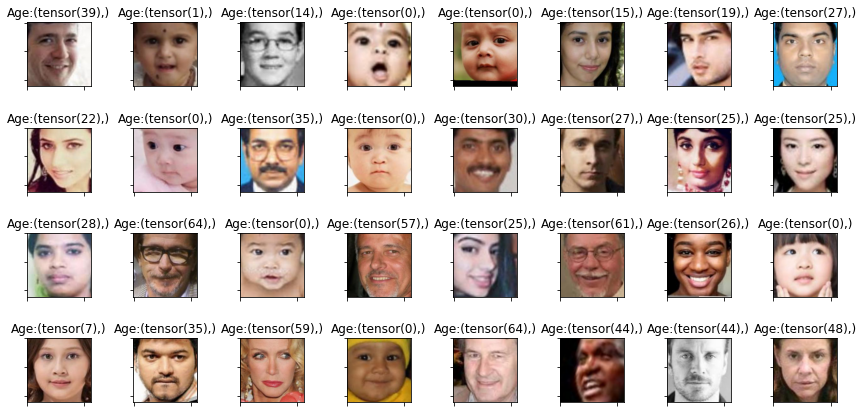

In [ ]:
# creamos cargador
trn_dl = torch.utils.data.DataLoader(
    # conjunto
    trn_ds,
    # tamaño del lote
    batch_size=BATCH_SIZE,
    # desordenar
    shuffle=True,
    # número de procesos paralelos
    num_workers=4
)
# desplegamos lote
batch = next(iter(trn_dl))
b_images, b_ages = batch[0] , batch[1]
titles = [f'Age:{b_age_i}' for b_age_i in zip(b_ages)]
print(f'b_images shape={b_images.shape} dtype={b_images.dtype}')
print(f'b_ages shape={b_ages.shape} dtype={b_ages.dtype}')
display_batch(b_images, titles, 4, 8)

In [ ]:
#######
# PPRUEBA
#######

# transformación de prueba
test_tsfm = T.Compose([
  # redimensionamos a Wx128 o 128xH
  T.Resize(IMG_SIZE),
  # cortamos al centro 128x128
  T.CenterCrop(IMG_SIZE),
  # convertimos a torch.Tensor [3,H,W]
  # escalamos a [0,1]
  T.ToTensor(),
  # estandarizamos con media y varianza
  T.Normalize(mean=UTKFACE_MEAN, std=UTKFACE_STD)
])

# conjunto
test_ds = utk_data_handler.get_datasubset(split='test', transform=test_tsfm)

b_images shape=torch.Size([32, 3, 224, 224]) dtype=torch.float32
b_ages shape=torch.Size([32]) dtype=torch.int64


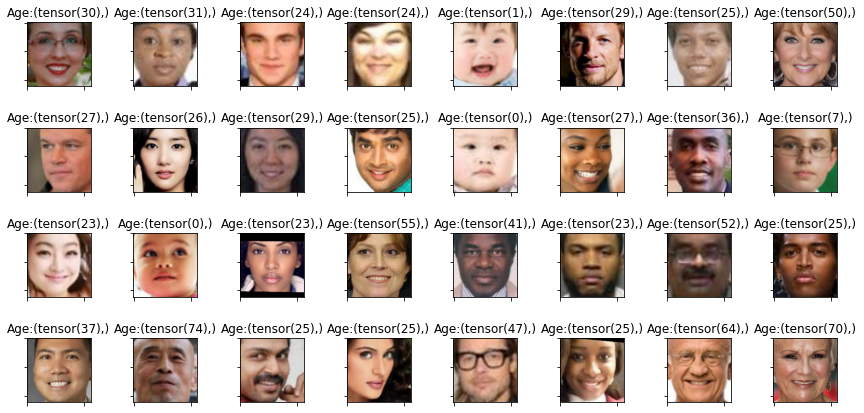

In [ ]:
# creamos cargador
test_dl = torch.utils.data.DataLoader(
    # conjunto
    test_ds,
    # tamaño del lote
    batch_size=BATCH_SIZE,
    # desordenar
    shuffle=True,
    # número de procesos paralelos
    num_workers=4
)
# desplegamos lote
batch = next(iter(test_dl))
b_images, b_ages = batch[0] , batch[1]
titles = [f'Age:{b_age_i}' for b_age_i in zip(b_ages)]
print(f'b_images shape={b_images.shape} dtype={b_images.dtype}')
print(f'b_ages shape={b_ages.shape} dtype={b_ages.dtype}')
display_batch(b_images, titles, 4, 8)

## Usando transferencia de conocimiento, entrenar un modelo reentrenando solo la última capa.

### Definición del modelo

In [ ]:
# instancia de modelo y carga de pesos
model = tvm.shufflenet_v2_x0_5(pretrained=True)
model

Downloading: "https://download.pytorch.org/models/shufflenetv2_x0.5-f707e7126e.pth" to /root/.cache/torch/hub/checkpoints/shufflenetv2_x0.5-f707e7126e.pth


ShuffleNetV2(
  (conv1): Sequential(
    (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (stage2): Sequential(
    (0): InvertedResidual(
      (branch1): Sequential(
        (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=24, bias=False)
        (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Conv2d(24, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (3): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (4): ReLU(inplace=True)
      )
      (branch2): Sequential(
        (0): Conv2d(24, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_

In [ ]:
# congelamos los parámetros
for param in model.parameters():
  param.requires_grad = False
# congelamos las estadísticas
model.eval()

# remplazo de última capa
model.fc = torch.nn.Linear(1024, 116)
# model.classifier[1] = torch.nn.Linear(1280, 116)
# model.classifier[1] = torch.nn.Conv2d(512, 116, kernel_size=(1,1), stride=(1,1))

# inspección
summary(model, (3, IMG_SIZE, IMG_SIZE), device='cuda', verbose=0)

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 24, 112, 112]        --
|    └─Conv2d: 2-1                       [-1, 24, 112, 112]        (648)
|    └─BatchNorm2d: 2-2                  [-1, 24, 112, 112]        (48)
|    └─ReLU: 2-3                         [-1, 24, 112, 112]        --
├─MaxPool2d: 1-2                         [-1, 24, 56, 56]          --
├─Sequential: 1-3                        [-1, 48, 28, 28]          --
|    └─InvertedResidual: 2-4             [-1, 48, 28, 28]          --
|    |    └─Sequential: 3-1              [-1, 24, 28, 28]          (888)
|    |    └─Sequential: 3-2              [-1, 24, 28, 28]          (1,512)
|    └─InvertedResidual: 2-5             [-1, 48, 28, 28]          --
|    |    └─Sequential: 3-3              [-1, 24, 28, 28]          (1,512)
|    └─InvertedResidual: 2-6             [-1, 48, 28, 28]          --
|    |    └─Sequential: 3-4              [-1, 24, 28, 28]          

### Funciones de entrenamiento

In [ ]:
def train_epoch(dl, model, opt):
  """Entrena una época"""
  # entrenamiento de una época
  for batch in dl:
    b_images = batch[0]
    b_ages = batch[1]
    b_images = b_images.to('cuda')
    b_ages = b_ages.to('cuda')
    # computamos logits
    age_lgts = model(b_images)
    # computamos la pérdida
    loss = F.cross_entropy(age_lgts, b_ages)
    # vaciamos los gradientes
    opt.zero_grad()
    # retropropagamos
    loss.backward()
    # actualizamos parámetros
    opt.step()

def eval_epoch(dl, model, num_batches=None):
  """Evalua una época"""
  # evitamos que se registren las operaciones 
  # en la gráfica de cómputo
  with torch.no_grad():
    losses, accs = [], []
    # validación de la época con num_batches
    # si num_batches==None, se usan todos los lotes
    for batch in take(dl, num_batches):
      b_images = batch[0]
      b_ages = batch[1]
      b_images = b_images.to('cuda')
      b_ages = b_ages.to('cuda')
      # hacemos inferencia para obtener los logits
      age_lgts = model(b_images)

      # computamos las probabilidades
      age_probs = F.softmax(age_lgts, 1)
      # obtenemos la clase predicha
      age_preds = torch.argmax(age_probs, 1)

      # computamos la pérdida
      loss = F.cross_entropy(age_lgts, b_ages)
      # computamos la exactitud
      acc = (b_ages == age_preds).type(torch.float32).mean()

      # guardamos históricos
      losses.append(loss.item())
      accs.append(acc.item())

    loss = np.mean(losses) * 100
    acc = np.mean(accs) * 100

    return loss, acc

def save_check_point(model, epoch, run_dir):
  """Guarda un punto de control."""
  torch.save(
    {
      'epoch': epoch,
      'model_state_dict': model.state_dict(),
    }, 
    os.path.join(run_dir, 'weights.pth')
  )

def train(model, trn_dl, val_dl, trn_writer, val_writer, epochs,
          trn_batches=None, val_batches=None):

  # optimizador
  opt = optim.Adam(model.parameters(), lr=1e-3)

  # modelo en modo de evaluación
  # para transferencia de conocimiento además de congelar los pesos, 
  # es importante congelar las estadísticas σ y μ 
  model.eval()
  model.to('cuda')

  # ciclo de entrenamiento
  best_acc = 0
  for epoch in trange(epochs):

    # entrenamos la época
    train_epoch(trn_dl, model, opt)

    # evaluamos la época en entrenamiento
    trn_loss, trn_acc = eval_epoch(trn_dl, model, trn_batches)
    # registramos trazas de TB 
    trn_writer.add_scalar('metrics/loss', trn_loss, epoch)
    trn_writer.add_scalar('metrics/acc', trn_acc, epoch)

    # evaluamos la época en validación
    val_loss, val_acc = eval_epoch(val_dl, model, val_batches)
    # registramos trazas de TB
    val_writer.add_scalar('metrics/loss', val_loss, epoch)
    val_writer.add_scalar('metrics/acc', val_acc, epoch)

    # si hay mejora guardar punto de control
    if val_acc > best_acc:
      best_acc = val_acc
      save_check_point(model, epoch, run_dir)

#### Monitoreo con tensorboard

In [ ]:
# directorio de la corrida
run_dir = os.path.join('runs', 'UTKFaceShuffleNet', timestamp())
run_dir

'runs/UTKFaceShuffleNet/201226T171745'

In [ ]:
# escritor de trazas
trn_writer = SummaryWriter(os.path.join(run_dir, 'trn'))
val_writer = SummaryWriter(os.path.join(run_dir, 'val'))

In [ ]:
# inspeccionemos el directorio de la corrida
!ls -R {run_dir}

runs/UTKFaceShuffleNet/201223T204458:
trn  val

runs/UTKFaceShuffleNet/201223T204458/trn:
events.out.tfevents.1608756299.a0a2f47f7eee.56.2

runs/UTKFaceShuffleNet/201223T204458/val:
events.out.tfevents.1608756299.a0a2f47f7eee.56.3


In [ ]:
# lanzamos Tensorboard
%load_ext tensorboard
%tensorboard --logdir runs/UTKFaceShuffleNet --host localhost

In [ ]:
# entrenamos modelo
train(model, trn_dl, test_dl, trn_writer, val_writer, epochs=20)

100%|██████████| 20/20 [34:22<00:00, 103.11s/it]


In [ ]:
# inspeccionemos el directorio de la corrida
!ls -R {run_dir}

runs/UTKFaceShuffleNet/201223T204458:
trn  val  weights.pth

runs/UTKFaceShuffleNet/201223T204458/trn:
events.out.tfevents.1608756299.a0a2f47f7eee.56.2

runs/UTKFaceShuffleNet/201223T204458/val:
events.out.tfevents.1608756299.a0a2f47f7eee.56.3


#### Evaluación al cargar el modelo 

In [ ]:
# cargamos el punto de contral
ckpt = torch.load(os.path.join(run_dir, 'weights.pth'))
# imprimimos la mejor época
best_epoch = ckpt['epoch']
print(f'Best epoch {best_epoch}')

Best epoch 18


In [ ]:
# instanciamos un modelo vacio
model = tvm.shufflenet_v2_x0_5()
model.fc = torch.nn.Linear(1024, 116)

# cargamos pesos
state_dict = ckpt['model_state_dict']
model.load_state_dict(state_dict)

# congelamos las estadísticas
_ = model.eval()
model.to('cuda')

ShuffleNetV2(
  (conv1): Sequential(
    (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (stage2): Sequential(
    (0): InvertedResidual(
      (branch1): Sequential(
        (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=24, bias=False)
        (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Conv2d(24, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (3): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (4): ReLU(inplace=True)
      )
      (branch2): Sequential(
        (0): Conv2d(24, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_

In [ ]:
trn_loss, trn_acc = eval_epoch(trn_dl, model)
test_loss, test_acc = eval_epoch(test_dl, model)

In [ ]:
print(f'trn_acc={trn_acc:5.2f} test_acc={test_acc:5.2f}')

trn_acc=18.86 test_acc=16.20


In [ ]:
print(f'trn_loss={trn_loss:6.2f} test_loss={test_loss:6.2f}')

trn_loss=321.26 test_loss=338.71


#### Inspección visual de resultados

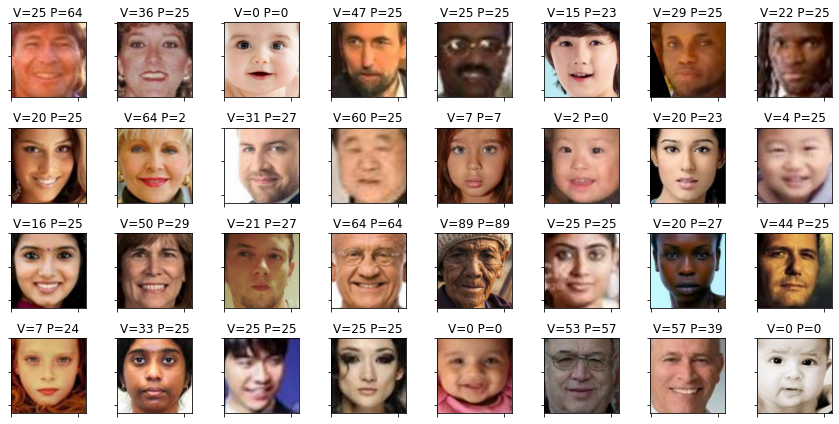

In [ ]:
with torch.no_grad():
  batch = next(iter(test_dl))
  b_images, b_ages = batch[0], batch[1]
  b_images = b_images.to('cuda')
  b_ages = b_ages.to('cuda')
  ages_pred = torch.argmax(F.softmax(model(b_images), 1), 1)
  titles = [f'V={t} P={p}' for t, p in zip(b_ages, ages_pred)]
  display_batch(b_images.to('cpu'), titles, 4, 8)

## Usando transferencia de conocimiento, entrenar un modelo reentrenando toda la red.

In [ ]:
# instancia de modelo y carga de pesos
model = tvm.shufflenet_v2_x0_5(pretrained=True)
model

Downloading: "https://download.pytorch.org/models/shufflenetv2_x0.5-f707e7126e.pth" to /root/.cache/torch/hub/checkpoints/shufflenetv2_x0.5-f707e7126e.pth


ShuffleNetV2(
  (conv1): Sequential(
    (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (stage2): Sequential(
    (0): InvertedResidual(
      (branch1): Sequential(
        (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=24, bias=False)
        (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Conv2d(24, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (3): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (4): ReLU(inplace=True)
      )
      (branch2): Sequential(
        (0): Conv2d(24, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_

In [ ]:
# congelamos las estadísticas
model.eval()

# remplazo de última capa
model.fc = torch.nn.Linear(1024, 116)

# inspección
summary(model, (3, IMG_SIZE, IMG_SIZE), device='cuda', verbose=0)

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 24, 112, 112]        --
|    └─Conv2d: 2-1                       [-1, 24, 112, 112]        648
|    └─BatchNorm2d: 2-2                  [-1, 24, 112, 112]        48
|    └─ReLU: 2-3                         [-1, 24, 112, 112]        --
├─MaxPool2d: 1-2                         [-1, 24, 56, 56]          --
├─Sequential: 1-3                        [-1, 48, 28, 28]          --
|    └─InvertedResidual: 2-4             [-1, 48, 28, 28]          --
|    |    └─Sequential: 3-1              [-1, 24, 28, 28]          888
|    |    └─Sequential: 3-2              [-1, 24, 28, 28]          1,512
|    └─InvertedResidual: 2-5             [-1, 48, 28, 28]          --
|    |    └─Sequential: 3-3              [-1, 24, 28, 28]          1,512
|    └─InvertedResidual: 2-6             [-1, 48, 28, 28]          --
|    |    └─Sequential: 3-4              [-1, 24, 28, 28]          1,512
|   

In [ ]:
# directorio de la corrida
run_dir = os.path.join('runs', 'UTKFaceShuffleNet', timestamp())
run_dir

'runs/UTKFaceShuffleNet/201228T185640'

In [ ]:
# escritor de trazas
trn_writer = SummaryWriter(os.path.join(run_dir, 'trn'))
val_writer = SummaryWriter(os.path.join(run_dir, 'val'))

In [ ]:
# inspeccionemos el directorio de la corrida
!ls -R {run_dir}

runs/UTKFaceShuffleNet/201228T185640:
trn  val

runs/UTKFaceShuffleNet/201228T185640/trn:
events.out.tfevents.1609181812.a2172709416e.59.0

runs/UTKFaceShuffleNet/201228T185640/val:
events.out.tfevents.1609181812.a2172709416e.59.1


In [ ]:
# lanzamos Tensorboard
%load_ext tensorboard
%tensorboard --logdir runs/UTKFaceShuffleNet --host localhost

In [ ]:
# entrenamos modelo
train(model, trn_dl, test_dl, trn_writer, val_writer, epochs=20)

100%|██████████| 20/20 [42:41<00:00, 128.06s/it]


In [ ]:
# inspeccionemos el directorio de la corrida
!ls -R {run_dir}

runs/UTKFaceShuffleNet/201228T185640:
trn  val  weights.pth

runs/UTKFaceShuffleNet/201228T185640/trn:
events.out.tfevents.1609181812.a2172709416e.59.0

runs/UTKFaceShuffleNet/201228T185640/val:
events.out.tfevents.1609181812.a2172709416e.59.1


In [ ]:
# cargamos el punto de control
ckpt = torch.load(os.path.join(run_dir, 'weights.pth'))
# imprimimos la mejor época
best_epoch = ckpt['epoch']
print(f'Best epoch {best_epoch}')

Best epoch 14


In [ ]:
# instanciamos un modelo vacio
model = tvm.shufflenet_v2_x0_5()
model.fc = torch.nn.Linear(1024, 116)

# cargamos pesos
state_dict = ckpt['model_state_dict']
model.load_state_dict(state_dict)

# congelamos las estadísticas
_ = model.eval()
model.to('cuda')

ShuffleNetV2(
  (conv1): Sequential(
    (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (stage2): Sequential(
    (0): InvertedResidual(
      (branch1): Sequential(
        (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=24, bias=False)
        (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Conv2d(24, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (3): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (4): ReLU(inplace=True)
      )
      (branch2): Sequential(
        (0): Conv2d(24, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_

In [ ]:
trn_loss, trn_acc = eval_epoch(trn_dl, model)
test_loss, test_acc = eval_epoch(test_dl, model)

In [ ]:
print(f'trn_acc={trn_acc:5.2f} test_acc={test_acc:5.2f}')

trn_acc=30.92 test_acc=18.03


In [ ]:
print(f'trn_loss={trn_loss:6.2f} test_loss={test_loss:6.2f}')

trn_loss=236.27 test_loss=314.74


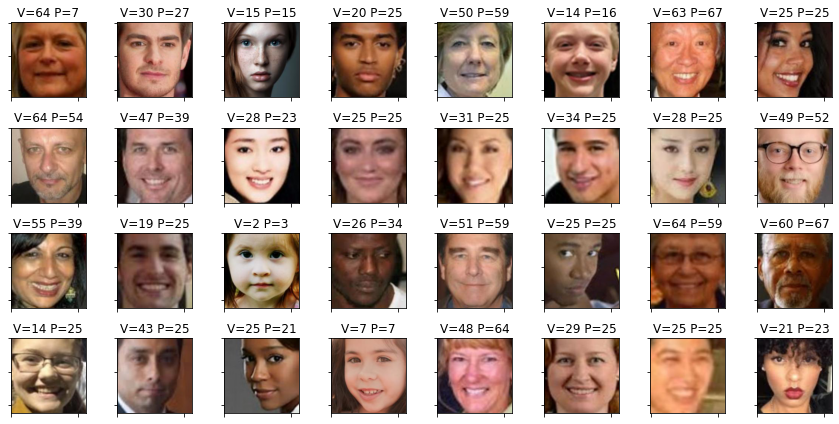

In [ ]:
with torch.no_grad():
  batch = next(iter(test_dl))
  b_images, b_ages = batch[0], batch[1]
  b_images = b_images.to('cuda')
  b_ages = b_ages.to('cuda')
  ages_pred = torch.argmax(F.softmax(model(b_images), 1), 1)
  titles = [f'V={t} P={p}' for t, p in zip(b_ages, ages_pred)]
  display_batch(b_images.to('cpu'), titles, 4, 8)